## Visualization of the superpixel images, graphs and edge connections

### Superpixels from
https://github.com/bknyaz/graph_attention_pool

In [3]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

### Functions definition for graph construction

In [137]:
def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)
    
    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)
        
    # Convert to symmetric matrix
    A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:   
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

### CIFARSuperPix class for reading superpixels file and constructing graph

In [140]:
class CIFARSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 split,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        self.split = split
        self.is_test = split.lower() in ['test', 'val']
        with open(os.path.join(data_dir, 'cifar10_150sp_%s.pkl' % split), 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 32

    def precompute_graph_images(self):
        print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]
            
            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features
            
            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

### Taking only coordinates for knn graph construction
This is done by setting `use_feat_for_graph_construct = False`.   
If you want to also consider the mean feature intensity of superpixels for the constructing the knn graphs, set `use_feat_for_graph_construct = True`

In [141]:
# Taking the test dataset only for sample visualization
use_feat_for_graph_construct = False
tt = time.time()
data_no_feat_knn = CIFARSuperPix("data/superpixels", 
                             split='test', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_no_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TEST set...
Time taken: 12.8934s


### Taking coordinates and features for knn graph construction

In [142]:
use_feat_for_graph_construct = True
tt = time.time()
data_with_feat_knn = CIFARSuperPix("data/superpixels", 
                             split='test', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TEST set...
Time taken: 17.0788s


### Prepare CIFAR10 Images

Files already downloaded and verified
Label:  frog


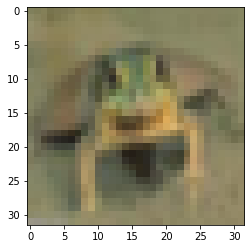

In [143]:
dataset = datasets.CIFAR10(root='PATH', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
x, label = dataset[4151] # x is now a torch.Tensor
npimg = x.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
print("Label: ", classes[label])

### Drawing a dgl graph using networkx

Label:  0


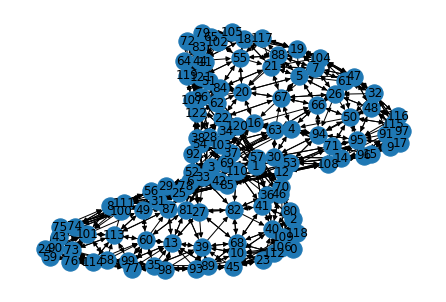

In [144]:
sample = np.random.choice(len(data_no_feat_knn))
g_sample = data_no_feat_knn[sample][0]
print("Label: ", data_no_feat_knn[sample][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

### Superpixels plot function definition

In [145]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

def plot_superpixels_graph(plt, sp_data, adj_matrix, label, feat_coord, with_edges):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = sp_data[0].mean(axis=1)
    label = classes[label]
    
    G = nx.from_numpy_matrix(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    title = "Label: " + str(label)
    if feat_coord:
        title += " | Using feat and coord for knn"
    else:
        title += " | Using only coord for knn"
    if not with_edges:
        title = "Label: " + str(label) + " | Only superpixel nodes"
    
    plt.title.set_text(title)
    
def show_image(plt, idx, alpha=1.0):
    x, label = dataset[idx] # x is now a torch.Tensor
    # img = x.numpy()[0]
    
    # x = x / 2 + 0.5 # unnormalize
    npimg = x.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.axis('off')
    plt.title.set_text("Label: " + str(classes[label]) + " | Original Image")

### Plotting sample superpixels, and graphs

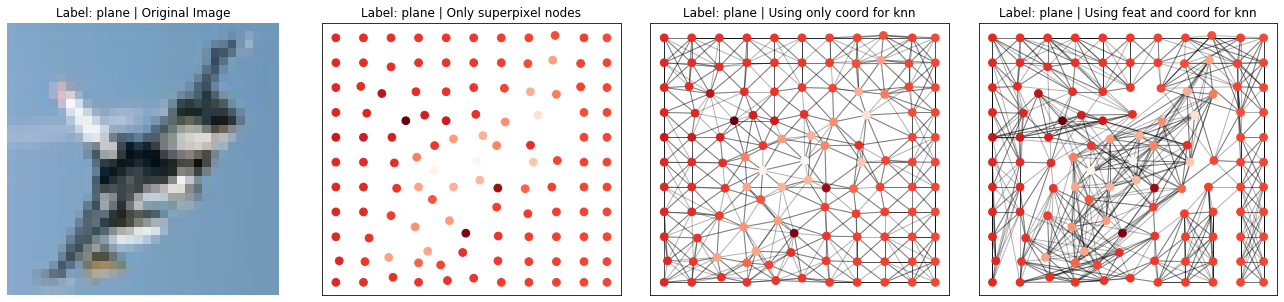

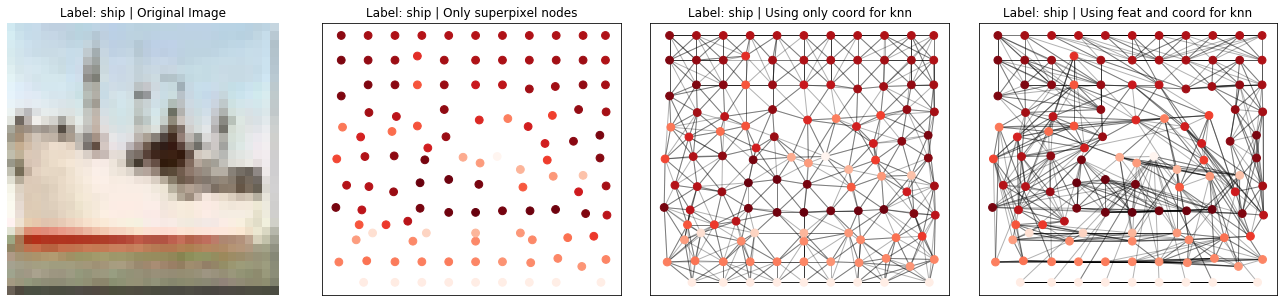

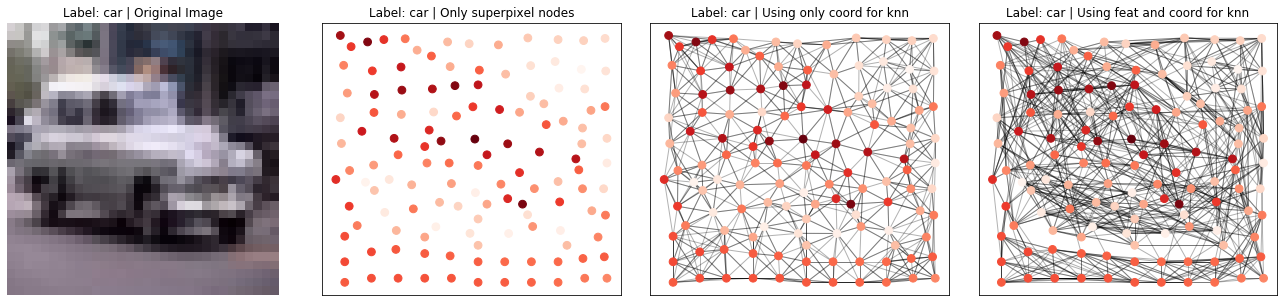

In [172]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(int(len(data_no_feat_knn)/2), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(23, 5))
    plt1 = f.add_subplot(141)
    show_image(plt1, idx)

    plt2 = f.add_subplot(142)  
    plot_superpixels_graph(plt2, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=False)

    plt3 = f.add_subplot(143)
    plot_superpixels_graph(plt3, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt4 = f.add_subplot(144)
    plot_superpixels_graph(plt4, data_with_feat_knn.sp_data[idx],
                           data_with_feat_knn.Adj_matrices[idx],
                           data_with_feat_knn[idx][1],
                           data_with_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    f.savefig('superpixels_visualization/cifar_superpix_'+str(idx)+'.jpg')
    plt.show()

### Get k-nearest neighbor distances for first 10 (denoted by [:10]) nodes for first graph (denoted by [0])

In [173]:
print(compute_edges_list(data_no_feat_knn.Adj_matrices[0])[1][:10])

[[6.03445324e-03 1.45011470e-02 2.32533634e-02 1.08872796e-01
  1.11688573e-01 2.40579283e-02 1.50693714e-01 1.59631685e-01]
 [3.40677565e-03 2.90870753e-02 3.33845184e-02 4.12177442e-02
  2.00054425e-01 1.51449026e-01 1.75068877e-01 7.82186288e-02]
 [1.26847227e-02 2.30322030e-02 1.64679408e-01 6.40388893e-02
  4.89638154e-02 2.17608378e-01 5.12098406e-02 1.83182785e-01]
 [2.84197353e-02 3.97304765e-02 2.67893181e-02 5.57380497e-02
  6.35204921e-02 1.19309234e-01 7.83242677e-02 8.64968535e-02]
 [5.76607756e-04 8.88246447e-04 2.64306730e-01 3.61304029e-02
  1.02635072e-01 1.16596661e-02 1.85920231e-01 2.14903099e-03]
 [2.21838500e-02 2.70385871e-02 2.36446401e-02 2.92655813e-02
  1.58587408e-01 9.74449696e-02 9.94594497e-02 4.75654057e-02]
 [2.33238909e-04 3.74770164e-03 1.41919962e-02 2.15553939e-02
  3.03801537e-01 2.47286381e-01 6.20250818e-02 1.04355025e-04]
 [4.38928717e-03 7.71996683e-03 8.09791381e-02 1.39282643e-02
  2.35816493e-01 1.63684982e-02 3.61304029e-02 2.01025650e-01]


In [174]:
print(compute_edges_list(data_with_feat_knn.Adj_matrices[0])[1][:10])

[[7.69898982e-05 9.18178881e-06 4.08132928e-02 1.64453022e-04
  1.91369026e-03 1.16721227e-06 2.69372405e-04 4.43337186e-05]
 [2.99196251e-11 7.24510309e-11 1.97807705e-10 3.13020946e-10
  3.32221557e-07 8.20077784e-06 2.09516493e-07 1.31396636e-09]
 [4.92506739e-11 2.08087770e-10 4.83745435e-05 7.17270744e-05
  2.09470463e-07 8.73653411e-05 9.88525372e-04 1.68799867e-03]
 [9.31469457e-11 1.17370557e-09 1.98961334e-05 1.25773462e-03
  2.26856898e-08 1.69963780e-06 5.87683871e-06 6.36520429e-07]
 [9.22093082e-09 7.03296363e-08 1.13348607e-06 8.69666965e-02
  2.16905178e-04 1.45724028e-04 5.71230145e-06 1.49687071e-02]
 [4.60336255e-10 9.20349064e-10 5.19048159e-07 6.34987652e-07
  7.57996652e-08 1.09712890e-09 7.99381644e-09 2.27939248e-02]
 [2.66561539e-09 3.87778176e-09 1.26805961e-02 2.87627226e-02
  7.15080628e-06 8.67555620e-08 1.10019863e-03 8.59704079e-06]
 [8.85932874e-07 1.04810807e-03 7.94322605e-03 5.36528704e-03
  2.16905178e-04 1.94833440e-05 2.74793291e-02 4.07342040e-02]
